/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMAX R² Score: -1.5196
ARIMAX MSE: 1672.1722
ARIMAX MAE: 34.6402


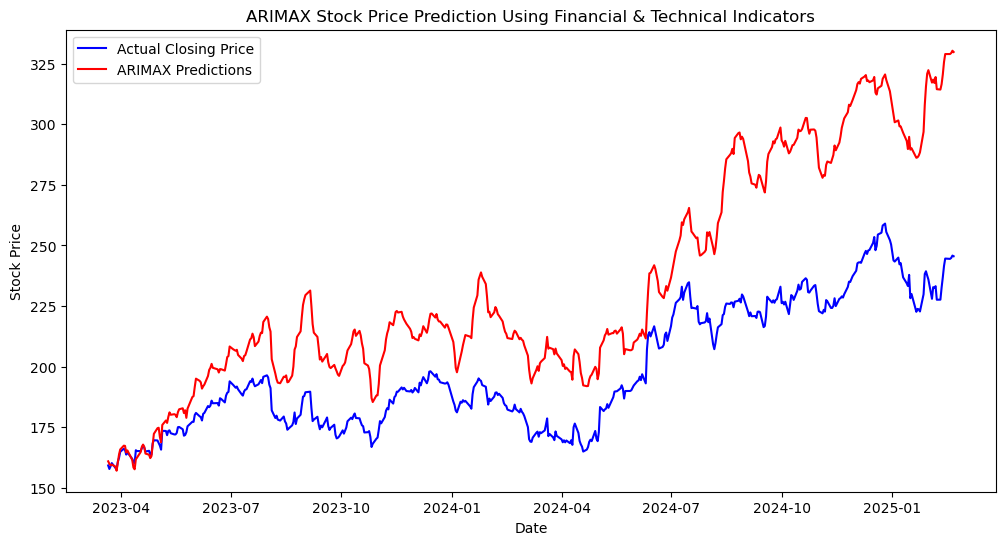

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("AAPL_final_merged.csv")

# Ensure dates are in datetime format
df["Date_x"] = pd.to_datetime(df["Date_x"])
df = df.sort_values("Date_x")

# Define selected financial and technical features
selected_features = [
    "ROE (%)", "ROA (%)", "Profit Margin (%)", "Debt/Equity", "FCF Margin (%)",
    "Estimated EPS", "Actual EPS", "RSI", "MACD", "Signal_Line", "MACD_Histogram",
    "ADX", "DX", "EMA_12", "EMA_26", "OBV"
]

# Target variable: Next day's closing price
target_column = "close_x"

# Drop rows with missing values in the selected features and target variable
df = df.dropna(subset=selected_features + [target_column])

# Normalize features
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(df[selected_features])
y_scaled = scaler_y.fit_transform(df[[target_column]])

# Convert scaled data back to DataFrame
df_scaled = pd.DataFrame(X_scaled, columns=selected_features)
df_scaled["Close Price"] = y_scaled

# Split into training and testing sets (80% train, 20% test)
train_size = int(len(df_scaled) * 0.8)
train_df, test_df = df_scaled[:train_size], df_scaled[train_size:]

# Define exogenous variables (X) and target variable (y)
X_train, X_test = train_df[selected_features], test_df[selected_features]
y_train, y_test = train_df["Close Price"], test_df["Close Price"]

# Fit ARIMAX model (AutoRegressive Integrated Moving Average with Exogenous Regressors)
model = SARIMAX(y_train, exog=X_train, order=(5, 1, 0), seasonal_order=(0, 0, 0, 0))
model_fit = model.fit(disp=False)

# Make predictions
y_pred_arimax = model_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1, exog=X_test)

# Inverse transform predictions back to original scale
y_pred_arimax_actual = scaler_y.inverse_transform(y_pred_arimax.values.reshape(-1, 1))
y_test_actual = scaler_y.inverse_transform(y_test.values.reshape(-1, 1))

# Compute evaluation metrics
arimax_r2 = r2_score(y_test_actual, y_pred_arimax_actual)
arimax_mse = mean_squared_error(y_test_actual, y_pred_arimax_actual)
arimax_mae = mean_absolute_error(y_test_actual, y_pred_arimax_actual)

# Display results
print(f"ARIMAX R² Score: {arimax_r2:.4f}")
print(f"ARIMAX MSE: {arimax_mse:.4f}")
print(f"ARIMAX MAE: {arimax_mae:.4f}")

# Plot actual vs predicted stock prices
plt.figure(figsize=(12, 6))
plt.plot(df["Date_x"][train_size:], y_test_actual, label="Actual Closing Price", color="blue")
plt.plot(df["Date_x"][train_size:], y_pred_arimax_actual, label="ARIMAX Predictions", color="red")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("ARIMAX Stock Price Prediction Using Financial & Technical Indicators")
plt.legend()
plt.show()
